In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display
import urllib.parse
from scipy.signal import argrelmax, argrelextrema

p = query.Prometheus('http://192.168.178.67:9090')
DEFAULT_STEP="1s"

DEBUG=False

# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.
NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]
# The default range for sliding window aggregations
DEFAULT_RANGE="10s"

# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = "{devices=\"\"}"

# Styling
sns.set_theme(style="ticks",palette="tab10")
sns.set_style("ticks",{'axes.grid' : True})

# Utils

In [2]:
def fetch_query_range(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0):
    start = start + offset_start
    end = end - offset_end
    if DEBUG:
        url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
        print(f"Querying '{query}' from {start} to {end} with step {step}: {url}")
    return p.query_range(query, start, end, step)

def prepare_query_range_as_dataframe(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0) -> pd.DataFrame:
    # url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
    # print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step}: {url}")
    # metrics = p.query_range(query, start, end, step)
    metrics = fetch_query_range(query, start, end, step, offset_start, offset_end)

    # We can't be sure that we have a value for each second, so we calculate the difference between the timestamps
    # and att those to the dataframe
    metrics['tvalue'] = metrics.index
    metrics['delta'] = (metrics['tvalue'] - metrics['tvalue'].min()).fillna(0).astype('timedelta64[s]')
    metrics['seconds'] = metrics['delta'].dt.total_seconds().astype(int)
    metrics.drop(['tvalue'], inplace=True, axis=1)
    
    # summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query, df, step=DEFAULT_STEP, offset_start=0, offset_end=0):
    result = [prepare_query_range_as_dataframe(query, start, end, step=step, offset_start=offset_start, offset_end=offset_end).assign(idx=idx) for idx, (start, end) in enumerate(zip(df['Start'], df['End']), 1)]
    result = pd.concat(result)
    return result

# Data Preparation

In [3]:
Q_POWER='{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}'
Q_CPU_SECONDS=f"sum by (mode) (increase(node_cpu_seconds_total[{DEFAULT_RANGE}]))"
Q_CPU_UTILIZATION=f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)"
Q_CPU_FREQUENCY="avg by (instance) (node_cpu_scaling_frequency_hertz)"
Q_MEMORY_USAGE=f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Cached_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Buffers_bytes[{DEFAULT_RANGE}])) / avg_over_time(node_memory_MemTotal_bytes[{DEFAULT_RANGE}])))
    """
Q_MEMORY_USED_BYTES="node_memory_MemTotal_bytes - node_memory_MemFree_bytes"
Q_NETWORK_RX_BYTES=f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_BYTES=f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_PACKETS=f"sum by(device) (increase(node_network_receive_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_PACKETS=f"sum by(device) (increase(node_network_transmit_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_RATE=f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_NETWORK_TX_RATE=f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_DISK_IO_SECONDS=f"node_disk_io_time_seconds_total{disk_filter_label}"
Q_DISK_IO_RATE=f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))"
Q_INTERRUPTS=f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{DEFAULT_RANGE}]) > 0)"

In [4]:
# This is just a try to load everything into a single dataframe.
# It's not working yet, but I'm going to leave it here for now.
def prepare_humongous_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    power_metrics = prepare_dataframe(Q_POWER, df).set_index(['measurement', 'seconds'])
    cpu_seconds = prepare_dataframe("avg by (mode) (node_cpu_seconds_total)", df).set_index(['measurement', 'seconds'])
    memory_free = prepare_dataframe("node_memory_MemFree_bytes", df).set_index(['measurement','seconds'])
    memory_chached = prepare_dataframe("node_memory_Cached_bytes", df).set_index(['measurement','seconds'])
    memory_buffers = prepare_dataframe("node_memory_Buffers_bytes", df).set_index(['measurement', 'seconds'])
    memory_total = prepare_dataframe("node_memory_MemTotal_bytes", df).set_index(['measurement', 'seconds'])
    network_receive_bytes = prepare_dataframe(f"node_network_receive_bytes_total{net_filter_label}", df).set_index(['measurement', 'seconds'])
    network_transmit_bytes = prepare_dataframe(f"node_network_transmit_bytes{net_filter_label}", df).set_index(['measurement', 'seconds'])
    disk_io_time_seconds = prepare_dataframe(f"node_disk_io_time_seconds_total{disk_filter_label}", df).set_index(['measurement', 'seconds'])
    interrupts = prepare_dataframe(f"sum by(devices, type) (node_interrupts_total{interrupts_filter} > 0)", df).set_index(['measurement', 'seconds'])

    df = pd.concat(
        [power_metrics, cpu_seconds, memory_free, memory_chached, memory_buffers, memory_total, network_receive_bytes, network_transmit_bytes, disk_io_time_seconds, interrupts], 
        axis=1,
        names=['measurement', 'seconds']
    )

    return df

# Scaling

In this section we will take a look how system properties scale to energy usages.
Several Benchmarks have been used to measure the factors

## CPU Usage

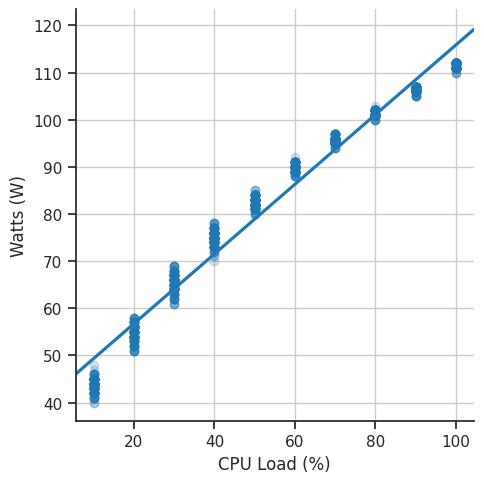

In [5]:
cpu_results = pd.read_csv('base/cpubench/cpubench-log.csv')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(cpu_results['Start'], cpu_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

cpu_results = power_metrics.join(cpu_results, on='idx')
cpu_results=cpu_results.reset_index()[['Watts', 'CPU Load']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=cpu_results, x="CPU Load", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("CPU Load (%)", "Watts (W)")
plt.show(fg)

## Memory Usage

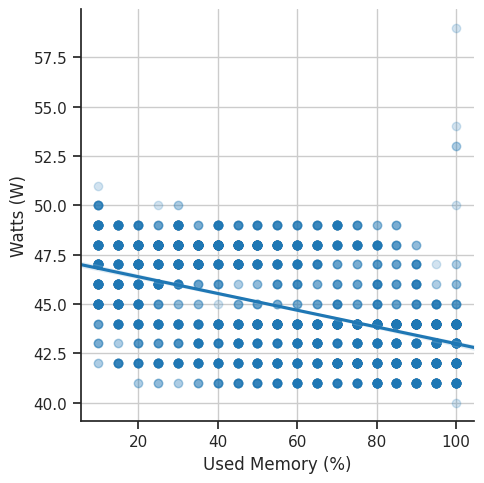

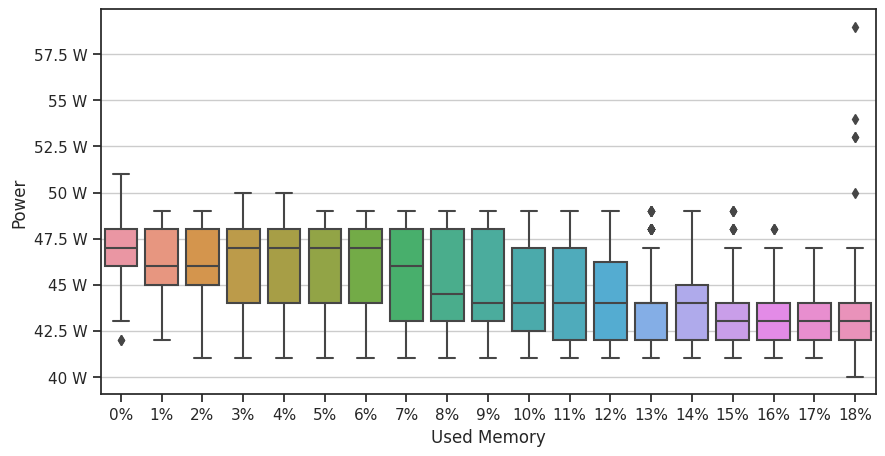

In [6]:
memory_results = pd.read_csv('base/membench/membench-log.csv')
memory_results['Used Memory'] = 100 * memory_results['Used Memory']
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(memory_results['Start'], memory_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

memory_results = power_metrics.join(memory_results, on='idx')
memory_results=memory_results.reset_index()[['Watts', 'Used Memory']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=memory_results, x="Used Memory", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("Used Memory (%)", "Watts (W)")
plt.show(fg)

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=memory_results, x="Used Memory", y="Watts"
)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set(xlabel="Used Memory", ylabel="Power")
plt.show(fig)


## Disk I/O

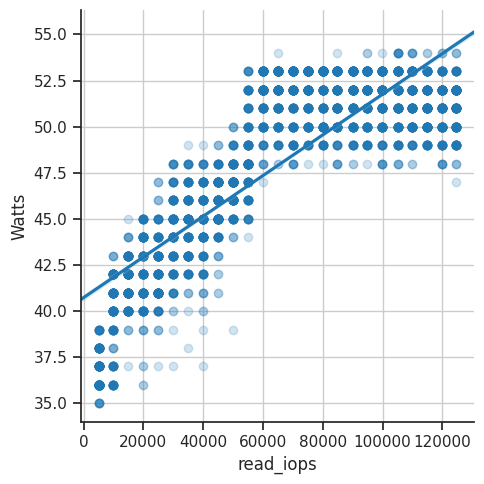

In [7]:
# Disk I/O
IO_RESULTS = pd.read_csv('base/iobench/iobench.csv', sep=';')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_io_results = power_metrics.join(IO_RESULTS, on='idx')
s_io_results=s_io_results.reset_index()[['Watts', 'read_iops']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=s_io_results, x="read_iops", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
plt.show(fg)

## Network I/O

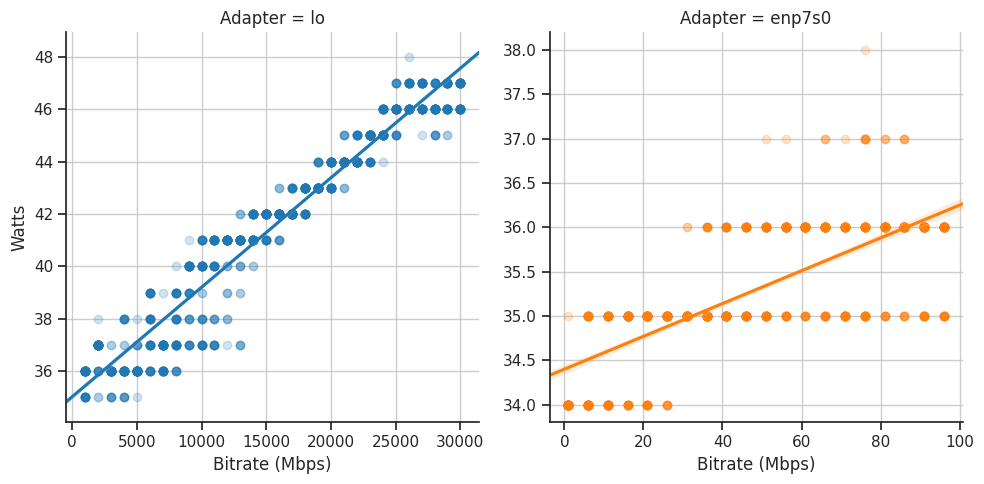

In [8]:
NET_RESULTS = pd.read_csv('base/netbench/netbench-log.csv', sep=',')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_net_results = power_metrics.join(NET_RESULTS, on='idx')

s_net_results=s_net_results.reset_index()[['Watts', 'Bitrate', 'Adapter']]
s_net_results['Bitrate'] = s_net_results['Bitrate'].astype(float).div(1000000) # To Mbps

fg = sns.lmplot(
    data=s_net_results, x="Bitrate", y="Watts", hue="Adapter", col="Adapter", scatter=True, truncate=False, scatter_kws={'alpha': .2},
    facet_kws=dict(sharex=False, sharey=False),
)
fg.axes[0,0].set_xlabel('Bitrate (Mbps)')
fg.axes[0,1].set_xlabel('Bitrate (Mbps)')
plt.show(fg)

## Summary

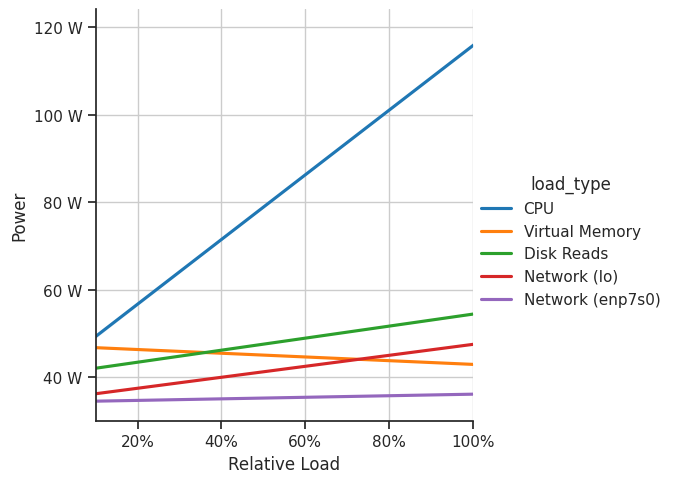

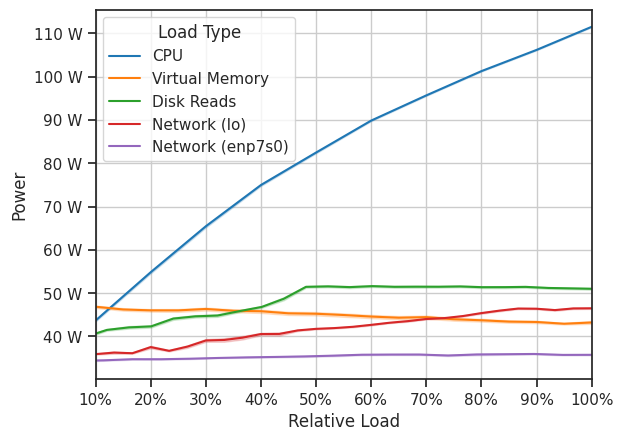

In [9]:
relative_cpu_results=cpu_results
relative_cpu_results['rel_load']=cpu_results['CPU Load'] / cpu_results['CPU Load'].max() * 100
relative_cpu_results=relative_cpu_results.assign(load_type='CPU')

relative_memory_results=memory_results
relative_memory_results['rel_load']=memory_results['Used Memory'] / memory_results['Used Memory'].max() * 100
relative_memory_results=relative_memory_results.assign(load_type='Virtual Memory')

relative_io_results=s_io_results
relative_io_results['rel_load']=s_io_results['read_iops'] / s_io_results['read_iops'].max() * 100
relative_io_results=relative_io_results.assign(load_type='Disk Reads')

relative_net_results=s_net_results
relative_net_results['rel_load']=relative_net_results.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
relative_net_results=relative_net_results.reset_index()
relative_net_results['load_type'] = relative_net_results.apply(lambda row: f"Network ({row['Adapter']})", axis=1)

# Watts | Relative Load | Type
relative_results = pd.concat([
    relative_cpu_results[['rel_load', 'Watts', 'load_type']],
    relative_memory_results[['rel_load', 'Watts', 'load_type']],
    relative_io_results[['rel_load', 'Watts', 'load_type']], 
    relative_net_results[['rel_load', 'Watts', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="Watts", hue="load_type", scatter=False, truncate=False
)
fg.axes[0,0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
fg.axes[0,0].yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes[0,0].set_xlim(10, 100)
fg.axes[0,0].set_xlabel('Relative Load')
fg.axes[0,0].set_ylabel('Power')
plt.show(fg)

fig, ax = plt.subplots()  
sns.lineplot(
    ax=ax,
    data=relative_results, x="rel_load", y="Watts", hue="load_type"
)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xlim(10, 100)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("Power")
ax.legend(title='Load Type')
plt.show(fig)

/tmp/ipykernel_7847/387653195.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in fg._legend.legendHandles:


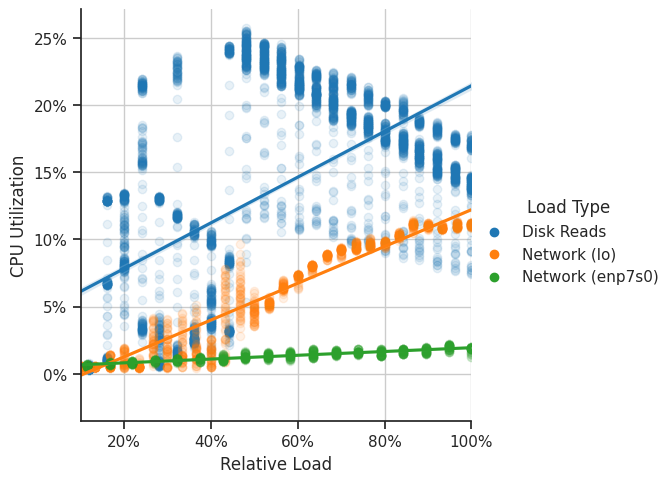

In [10]:
net_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
])
net_cpu_utilization = net_cpu_utilization.join(NET_RESULTS, on='idx')
net_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
net_cpu_utilization['utilization'] = net_cpu_utilization.iloc[:, 1:7].sum(axis=1)
net_cpu_utilization['rel_load']=net_cpu_utilization.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
net_cpu_utilization['load_type'] = net_cpu_utilization.apply(lambda row: f"Network ({row['Adapter']})", axis=1)
net_cpu_utilization=net_cpu_utilization.reset_index()

io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.assign(load_type='Disk Reads')
io_cpu_utilization=io_cpu_utilization.reset_index()

relative_results = pd.concat([
    io_cpu_utilization[['rel_load', 'utilization', 'load_type']],
    net_cpu_utilization[['rel_load', 'utilization', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="utilization", hue="load_type", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlim(10, 100)
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")
fg._legend.set_title('Load Type')

for lh in fg._legend.legendHandles:
    lh.set_alpha(1)

plt.show(fg)

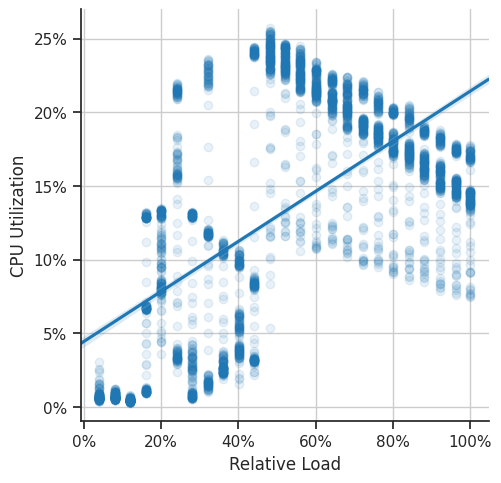

In [11]:
io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.reset_index()
#display(io_cpu_utilization)


fg = sns.lmplot(
    data=io_cpu_utilization, x="rel_load", y="utilization", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")

plt.show(fg)

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [12]:
bm = pd.read_csv('base/baseline.csv')
bm

,Start,End,Duration,Energy
0,1682782920,1682783220,5m,2


## Power Stats

count    301.000000
mean      33.006645
std        0.081378
min       33.000000
25%       33.000000
50%       33.000000
75%       33.000000
max       34.000000
Name: Watts, dtype: float64

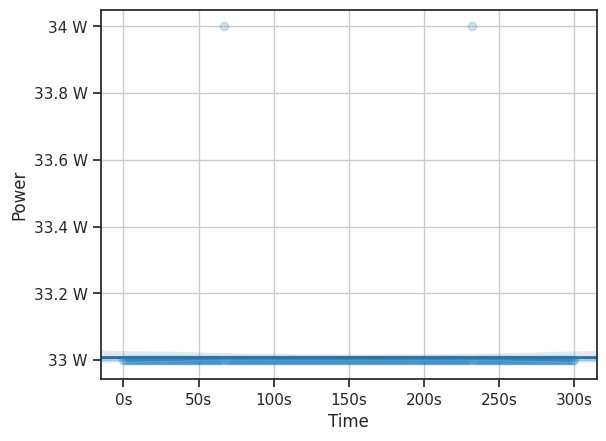

In [13]:
power_metrics = pd.concat([
    prepare_query_range_as_dataframe(Q_POWER, start, end).assign(idx=idx) for idx, (start, end) in enumerate(zip(bm['Start'], bm['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

display(power_metrics['Watts'].describe())

fg = sns.regplot(
    data=power_metrics, x="seconds", y="Watts", scatter=True, truncate=False,
    scatter_kws={'alpha': .2}
)
fg.axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}s'))
fg.axes.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes.set_xlabel('Time')
fg.axes.set_ylabel('Power')
plt.show(fg)

# Case Study 1: Caching

In [14]:
# Those are the variants we have measured
CACHE_VARIANTS=["no-cache", "caffeine-cache", "redis-cache"]
CACHE_VARIANTS_TRANSLATIONS={
    "no-cache": "No Cache",
    "caffeine-cache": "Caffeine Cache",
    "redis-cache": "Redis Cache"
}
data_measurement = pd.read_csv("case-study-caching/benchmark-log.csv")

In [15]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

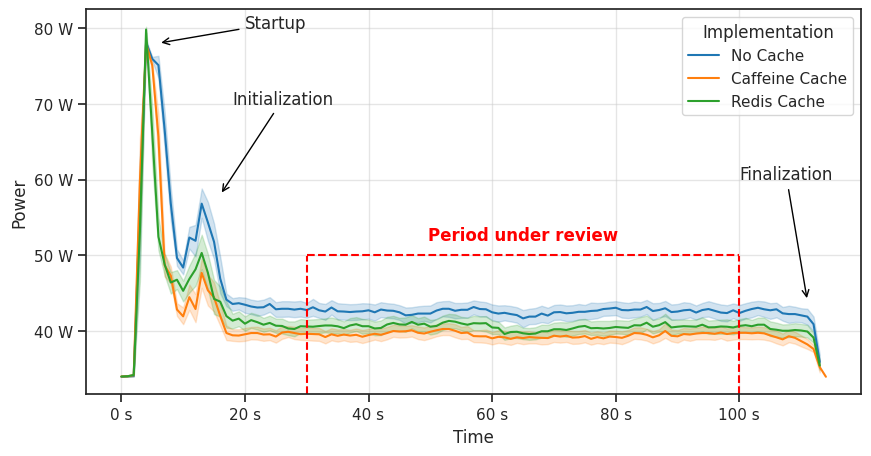

In [16]:
# We take a look at the measurements over time and see that we have an initializing and a finalizing phase. 
# We will cut those out and only look at the measurements in between.
f = plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=POWER_METRICS, x="seconds", y="Watts", hue="variant"
)

SECONDS_MIN=30
SECONDS_MAX=100

ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.grid(alpha=0.5)
plt.axvline(x=SECONDS_MIN, color='r', linestyle='--', ymin=0, ymax=0.36)
plt.axvline(x=SECONDS_MAX, color='r', linestyle='--', ymin=0, ymax=0.36)
plt.axhline(y=50, color='r', linestyle='--', xmin=0.2845, xmax=0.843)
plt.annotate(text='Startup', xy=(6,78), xytext=(20,80), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(text='Initialization', xy=(16,58), xytext=(18,70), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(text='Finalization', xy=(111,44), xytext=(100,60), arrowprops=dict(arrowstyle="->", color='black'))
plt.text(65, 52, 'Period under review', fontsize=12, color='r', fontweight='semibold', horizontalalignment='center')
ax.set_xlabel("Time")
ax.set_ylabel("Power")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
plt.show()

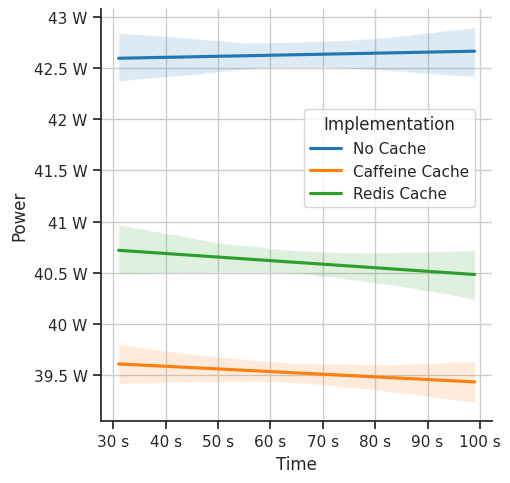

In [17]:
POWER_METRICS_INTERVAL = POWER_METRICS.loc[(POWER_METRICS['seconds'] > SECONDS_MIN) & (POWER_METRICS['seconds'] < SECONDS_MAX)]

g = sns.lmplot(
    data=POWER_METRICS_INTERVAL, x="seconds", y="Watts", hue="variant", scatter=False, legend=False
)
ax = g.axes[0,0]
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
sns.move_legend(ax, "best", bbox_to_anchor=(0.5, 0.5))
plt.show()

In [18]:
# TODO: make the code cleaner. It works, but it's not pretty.

POWER_CONSUMPTION = POWER_METRICS_INTERVAL.groupby(by=['variant'])['Watts'].describe().round(2)
POWER_CONSUMPTION.sort_values(by=['mean'], inplace=True, ascending=False)
REF_1 = POWER_CONSUMPTION.loc['no-cache']
POWER_CONSUMPTION.index = POWER_CONSUMPTION.index.map(CACHE_VARIANTS_TRANSLATIONS)
POWER_CONSUMPTION = POWER_CONSUMPTION[['mean', '50%', 'std', 'min', '25%', '75%', 'max']]

PC_1 = POWER_CONSUMPTION.copy()
PC_1['mean'] = PC_1['mean'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['mean'] * 100) - 100).round(2)))
PC_1['std'] = PC_1['std'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['std'] * 100) - 100).round(2)))
PC_1['min'] = PC_1['min'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['min'] * 100) - 100).round(2)))
PC_1['25%'] = PC_1['25%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['25%'] * 100) - 100).round(2)))
PC_1['50%'] = PC_1['50%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['50%'] * 100) - 100).round(2)))
PC_1['75%'] = PC_1['75%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['75%'] * 100) - 100).round(2)))
PC_1['max'] = PC_1['max'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_1['max'] * 100) - 100).round(2)))
display(PC_1)

# And now also with baseline power consumption excluded
BASELINE_POWER=33
POWER_CONSUMPTION = POWER_METRICS_INTERVAL.copy()
POWER_CONSUMPTION['Watts'] = POWER_CONSUMPTION['Watts'].apply(lambda x: x - BASELINE_POWER)
POWER_CONSUMPTION = POWER_CONSUMPTION.groupby(by=['variant'])['Watts'].describe().round(2)
POWER_CONSUMPTION.sort_values(by=['mean'], inplace=True, ascending=False)
REF_2 = POWER_CONSUMPTION.loc['no-cache']
POWER_CONSUMPTION.index = POWER_CONSUMPTION.index.map(CACHE_VARIANTS_TRANSLATIONS)
POWER_CONSUMPTION = POWER_CONSUMPTION[['mean', '50%', 'std', 'min', '25%', '75%', 'max']]

PC_2 = POWER_CONSUMPTION.copy()
PC_2['mean'] = PC_2['mean'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['mean'] * 100) - 100).round(2)))
PC_2['std'] = PC_2['std'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['std'] * 100) - 100).round(2)))
PC_2['min'] = PC_2['min'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['min'] * 100) - 100).round(2)))
PC_2['25%'] = PC_2['25%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['25%'] * 100) - 100).round(2)))
PC_2['50%'] = PC_2['50%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['50%'] * 100) - 100).round(2)))
PC_2['75%'] = PC_2['75%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['75%'] * 100) - 100).round(2)))
PC_2['max'] = PC_2['max'].apply(lambda x: "{} ({}%)".format(x, ((x / REF_2['max'] * 100) - 100).round(2)))
display(PC_2)


,mean,50%,std,min,25%,75%,max
variant,,,,,,,
No Cache,42.63 (0.0%),45.0 (0.0%),2.89 (0.0%),38.0 (0.0%),39.0 (0.0%),45.0 (0.0%),50.0 (0.0%)
Redis Cache,40.6 (-4.76%),39.0 (-13.33%),2.59 (-10.38%),38.0 (0.0%),38.0 (-2.56%),43.0 (-4.44%),47.0 (-6.0%)
Caffeine Cache,39.53 (-7.27%),39.0 (-13.33%),2.3 (-20.42%),37.0 (-2.63%),37.0 (-5.13%),42.0 (-6.67%),47.0 (-6.0%)


,mean,50%,std,min,25%,75%,max
variant,,,,,,,
No Cache,9.63 (0.0%),12.0 (0.0%),2.89 (0.0%),5.0 (0.0%),6.0 (0.0%),12.0 (0.0%),17.0 (0.0%)
Redis Cache,7.6 (-21.08%),6.0 (-50.0%),2.59 (-10.38%),5.0 (0.0%),5.0 (-16.67%),10.0 (-16.67%),14.0 (-17.65%)
Caffeine Cache,6.53 (-32.19%),6.0 (-50.0%),2.3 (-20.42%),4.0 (-20.0%),4.0 (-33.33%),9.0 (-25.0%),14.0 (-17.65%)


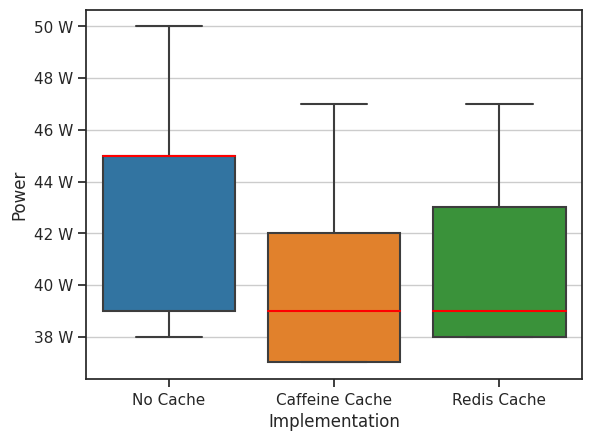

In [19]:
f, ax = plt.subplots()
sns.boxplot(x="variant", y="Watts", data=POWER_METRICS_INTERVAL, medianprops=dict(color='r'))
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS_INTERVAL, size=4, color=".3", linewidth=0, alpha=.5)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xticklabels(['No Cache', 'Caffeine Cache', 'Redis Cache'])
ax.set_xlabel("Implementation")
ax.set_ylabel("Power")
plt.show()

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,2070.0,11.10,1.39,7.72,9.92,11.27,12.22,14.63
no-cache,2070.0,17.37,1.48,14.31,16.11,16.82,18.91,20.52
redis-cache,2070.0,15.09,1.51,11.47,13.74,15.51,16.41,17.91


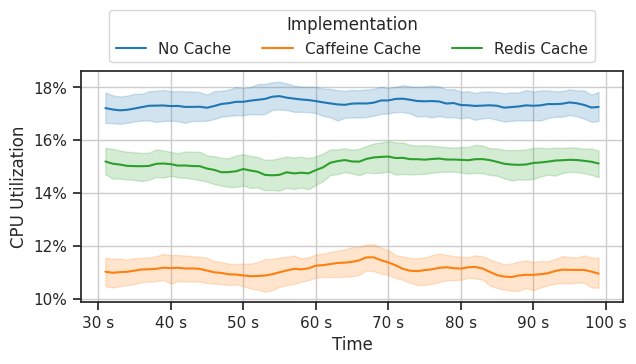

In [20]:
CPU_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
# Remember we want to cut out the initializing and finalizing phase
CPU_UTILIZATION_INTERVAL = CPU_UTILIZATION.loc[(CPU_UTILIZATION['seconds'] > SECONDS_MIN) & (CPU_UTILIZATION['seconds'] < SECONDS_MAX)]
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
_CPU_UTILIZATION_INTERVAL = CPU_UTILIZATION_INTERVAL.loc[:, ['seconds', 'variant', 'utilization']]

CPU_UTILIZATION_TABLE = _CPU_UTILIZATION_INTERVAL.groupby(by=['variant'])['utilization'].describe().round(2)
display(CPU_UTILIZATION_TABLE)

f = plt.figure(figsize=(7,3))
ax = sns.lineplot(
    data=_CPU_UTILIZATION_INTERVAL, x="seconds", y="utilization", hue="variant"
)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Time")
ax.set_ylabel("CPU Utilization")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.3), ncol=3)
plt.show(f)

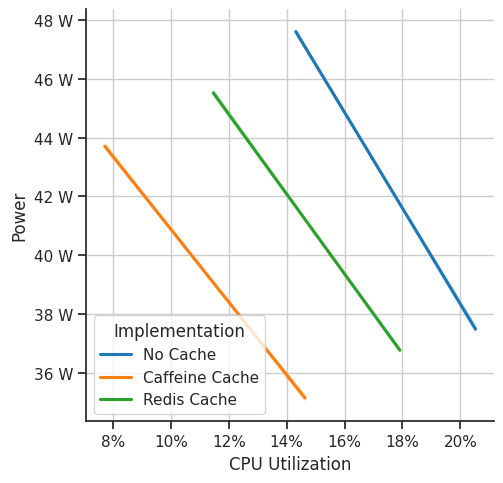

In [21]:
# Now we want to see how the CPU utilization relates to the power consumption
CPU_UTILIZATION_POWER_INTERVAL = pd.concat([CPU_UTILIZATION_INTERVAL.set_index(['seconds', 'idx', 'variant']), POWER_METRICS_INTERVAL.set_index(['seconds', 'idx', 'variant'])], axis=1).reset_index()

g = sns.lmplot(
    data=CPU_UTILIZATION_POWER_INTERVAL, x="utilization", y="Watts", hue="variant",
    scatter=False, legend=False
)
ax = g.axes[0,0]
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("CPU Utilization")
ax.set_ylabel("Power")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 0))
plt.show(g)

In [22]:
CPU_SECONDS = pd.concat(
    [prepare_dataframe(Q_CPU_SECONDS, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# Remember we want to cut out the initializing and finalizing phase
CPU_SECONDS_INTERVAL = CPU_SECONDS.loc[(CPU_SECONDS['seconds'] > SECONDS_MIN) & (CPU_SECONDS['seconds'] < SECONDS_MAX)]

In [23]:
# Let's take a look if we can find a correlation between CPU seconds spend in mode
# and the power consumption.
# Note that we don't really need to cut out the initializing and finalizing phase here
CPU_SECONDS_POWER = pd.concat([CPU_SECONDS.set_index(['seconds', 'idx', 'variant']), POWER_METRICS.set_index(['seconds', 'idx', 'variant'])], axis=1)
CPU_SECONDS_POWER = CPU_SECONDS_POWER[['{mode="idle"}', '{mode="iowait"}', '{mode="softirq"}', '{mode="system"}', '{mode="user"}', 'Watts']]

# I don't see a strong correlation here.
display(CPU_SECONDS_POWER.corr())

,"{mode=""idle""}","{mode=""iowait""}","{mode=""softirq""}","{mode=""system""}","{mode=""user""}",Watts
"{mode=""idle""}",1.000000,-0.444535,0.019707,-0.557731,-0.967109,-0.402956
"{mode=""iowait""}",-0.444535,1.000000,-0.585279,-0.202409,0.564553,0.372097
"{mode=""softirq""}",0.019707,-0.585279,1.000000,0.754900,-0.246082,-0.447857
"{mode=""system""}",-0.557731,-0.202409,0.754900,1.000000,0.360986,-0.121740
"{mode=""user""}",-0.967109,0.564553,-0.246082,0.360986,1.000000,0.510565
Watts,-0.402956,0.372097,-0.447857,-0.121740,0.510565,1.000000


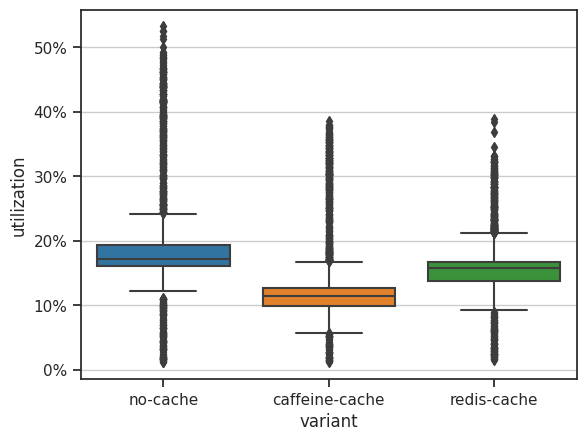

In [24]:
f, ax = plt.subplots()
sns.boxplot(x="variant", y="utilization", data=CPU_UTILIZATION)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS_INTERVAL, size=4, color=".3", linewidth=0, alpha=.5)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
plt.show()

/tmp/ipykernel_7847/273252237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MEMORY_UTILIZATION_INTERVAL['usage'] = MEMORY_UTILIZATION['{instance="192.168.178.81:9100",job="node"}']


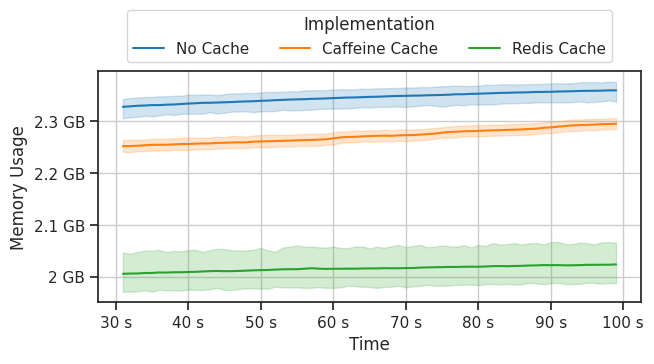

In [25]:
MEMORY_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_MEMORY_USED_BYTES, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# Remember we want to cut out the initializing and finalizing phase
MEMORY_UTILIZATION_INTERVAL = MEMORY_UTILIZATION.loc[(MEMORY_UTILIZATION['seconds'] > SECONDS_MIN) & (MEMORY_UTILIZATION['seconds'] < SECONDS_MAX)]
MEMORY_UTILIZATION_INTERVAL['usage'] = MEMORY_UTILIZATION['{instance="192.168.178.81:9100",job="node"}']

f = plt.figure(figsize=(7,3))
ax = sns.lineplot(
    data=MEMORY_UTILIZATION_INTERVAL, x="seconds", y="usage", hue="variant"
)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='B'))
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.3), ncol=3)
plt.show(f)

/tmp/ipykernel_7847/3809231808.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DISK_IO_SECONDS_INTERVAL['disk_io_seconds'] = DISK_IO_SECONDS_INTERVAL['node_disk_io_time_seconds_total{device="sda",instance="192.168.178.81:9100",job="node"}']


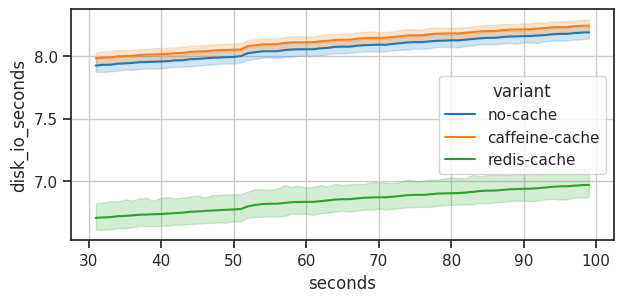

In [26]:
DISK_IO_SECONDS = pd.concat(
    [prepare_dataframe(Q_DISK_IO_SECONDS, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# Remember we want to cut out the initializing and finalizing phase
DISK_IO_SECONDS_INTERVAL = DISK_IO_SECONDS.loc[(DISK_IO_SECONDS['seconds'] > SECONDS_MIN) & (DISK_IO_SECONDS['seconds'] < SECONDS_MAX)]
DISK_IO_SECONDS_INTERVAL['disk_io_seconds'] = DISK_IO_SECONDS_INTERVAL['node_disk_io_time_seconds_total{device="sda",instance="192.168.178.81:9100",job="node"}']

f = plt.figure(figsize=(7,3))
ax = sns.lineplot(
    data=DISK_IO_SECONDS_INTERVAL, x="seconds", y="disk_io_seconds", hue="variant"
)
# ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=1))
# ax.set_xlabel("Time")
# ax.set_ylabel("Memory Utilization")
# legend_handles, _= ax.get_legend_handles_labels()
# ax.legend(legend_handles, ['No Cache', 'Caffeine Cache', 'Redis Cache'], title='Implementation')
# sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.3), ncol=3)
plt.show(f)

In [27]:
# For the efficiency we want to see how much power we need for a certain amount of requests has been consumed
# In order to do that we need to know how many requests have been processed in the interval
K6_THROUGHPUT = pd.concat(
    [prepare_dataframe("k6_iterations_total", data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# As the metrc is a resettable Gauge, we can pick the values in our observable range and 
K6_THROUGHPUT = K6_THROUGHPUT.loc[(K6_THROUGHPUT['seconds'] == SECONDS_MIN) | (K6_THROUGHPUT['seconds'] == SECONDS_MAX)]
#K6_THROUGHPUT.columns.values[0] = 'throughput'
K6_THROUGHPUT.rename(columns={'k6_iterations_total{scenario="default"}': 'throughput'}, inplace=True)
K6_THROUGHPUT['throughput'] = K6_THROUGHPUT['throughput'].diff()
K6_THROUGHPUT = K6_THROUGHPUT.loc[(K6_THROUGHPUT['throughput'] > 0)]

K6_THROUGHPUT[['variant', 'throughput']].groupby('variant').describe().round(0)

throughput                                                      
                    count     mean   std      min      25%      50%      75%   
variant                                                                        
caffeine-cache       30.0  51457.0  19.0  51388.0  51457.0  51462.0  51466.0  \
no-cache             30.0  51466.0  24.0  51416.0  51458.0  51465.0  51473.0   
redis-cache          30.0  51451.0  44.0  51323.0  51432.0  51462.0  51474.0   

                         
                    max  
variant                  
caffeine-cache  51492.0  
no-cache        51510.0  
redis-cache     51511.0

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,30.0,51456.67,18.89,51388.0,51457.00,51461.5,51465.75,51492.0
no-cache,30.0,51465.60,24.28,51416.0,51457.50,51465.0,51473.00,51510.0
redis-cache,30.0,51451.43,44.24,51323.0,51431.75,51462.5,51473.75,51511.0


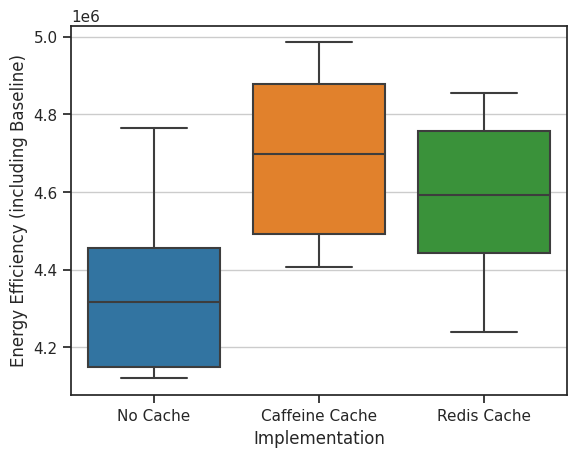

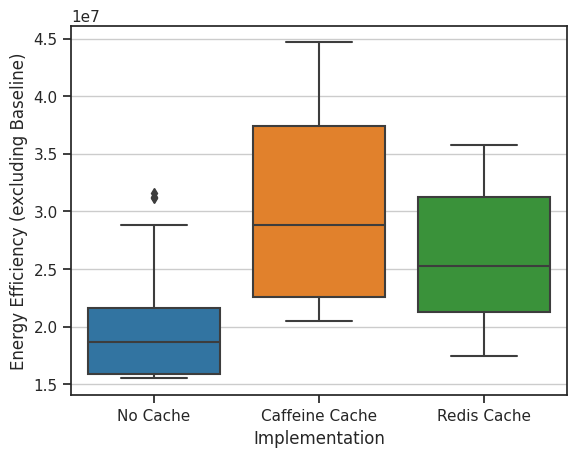

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,30.0,4694853.75 (7.75%),200687.19 (-8.42%),4408284.39 (6.99%),4493037.82 (8.29%),4699066.67 (8.83%),4877221.82 (9.45%),4985251.35 (4.6%)
no-cache,30.0,4357108.78 (0.0%),219128.21 (0.0%),4120300.97 (0.0%),4148931.73 (0.0%),4317758.7 (0.0%),4456133.84 (0.0%),4765816.11 (0.0%)
redis-cache,30.0,4570774.23 (4.9%),204610.62 (-6.63%),4239926.1 (2.9%),4444326.51 (7.12%),4593423.21 (6.38%),4756721.69 (6.75%),4854071.47 (1.85%)


In [28]:
# Now we can calculate the efficiency
# I think we can safeley concat the dataframes as they have the same index
POWER_CONSUMPTION = POWER_METRICS_INTERVAL.groupby(by=['variant', 'idx'])['Watts'].describe()
USEFUL_WORK = K6_THROUGHPUT.set_index(['variant', 'idx'])
display(K6_THROUGHPUT.groupby(by=['variant'])['throughput'].describe().round(2))

EFFICIENCY = pd.concat([USEFUL_WORK, POWER_CONSUMPTION], axis=1)
# Let's grab our interval and use it to caculate the efficiency in Watts per second
# We will use the mean power consumption of the interval as our consumd power unit.
TO_WATTH = 3600
EFFICIENCY['efficiency'] = EFFICIENCY['throughput'] / (EFFICIENCY['mean']) * TO_WATTH
EFFICIENCY['efficiency_wo_baseline'] = EFFICIENCY['throughput'] / ((EFFICIENCY['mean'] - BASELINE_POWER)) * TO_WATTH
EFFICIENCY = EFFICIENCY.reset_index()

f, ax = plt.subplots()
sns.boxplot(x="variant", y="efficiency", data=EFFICIENCY)
#ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xticklabels(['No Cache', 'Caffeine Cache', 'Redis Cache'])
ax.set_xlabel("Implementation")
ax.set_ylabel("Energy Efficiency (including Baseline)")
plt.show()

f, ax = plt.subplots()
sns.boxplot(x="variant", y="efficiency_wo_baseline", data=EFFICIENCY)
#ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xticklabels(['No Cache', 'Caffeine Cache', 'Redis Cache'])
ax.set_xlabel("Implementation")
ax.set_ylabel("Energy Efficiency (excluding Baseline)")
plt.show()



EFFICIENCY = EFFICIENCY.groupby(by=['variant'])['efficiency'].describe().round(2)
REF = EFFICIENCY.loc['no-cache']
EFFICIENCY['mean'] = EFFICIENCY['mean'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['mean'] * 100) - 100).round(2)))
EFFICIENCY['std'] = EFFICIENCY['std'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['std'] * 100) - 100).round(2)))
EFFICIENCY['min'] = EFFICIENCY['min'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['min'] * 100) - 100).round(2)))
EFFICIENCY['25%'] = EFFICIENCY['25%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['25%'] * 100) - 100).round(2)))
EFFICIENCY['50%'] = EFFICIENCY['50%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['50%'] * 100) - 100).round(2)))
EFFICIENCY['75%'] = EFFICIENCY['75%'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['75%'] * 100) - 100).round(2)))
EFFICIENCY['max'] = EFFICIENCY['max'].apply(lambda x: "{} ({}%)".format(x, ((x / REF['max'] * 100) - 100).round(2)))
display(EFFICIENCY)

In [29]:
TO_EXPORT = [
    
]

# Case Study 2: Dungeon

In [30]:
VARIANTS=["microservice", "monolith"]
data_measurement = pd.read_csv("case-study-dungeon/benchmark-log.csv")

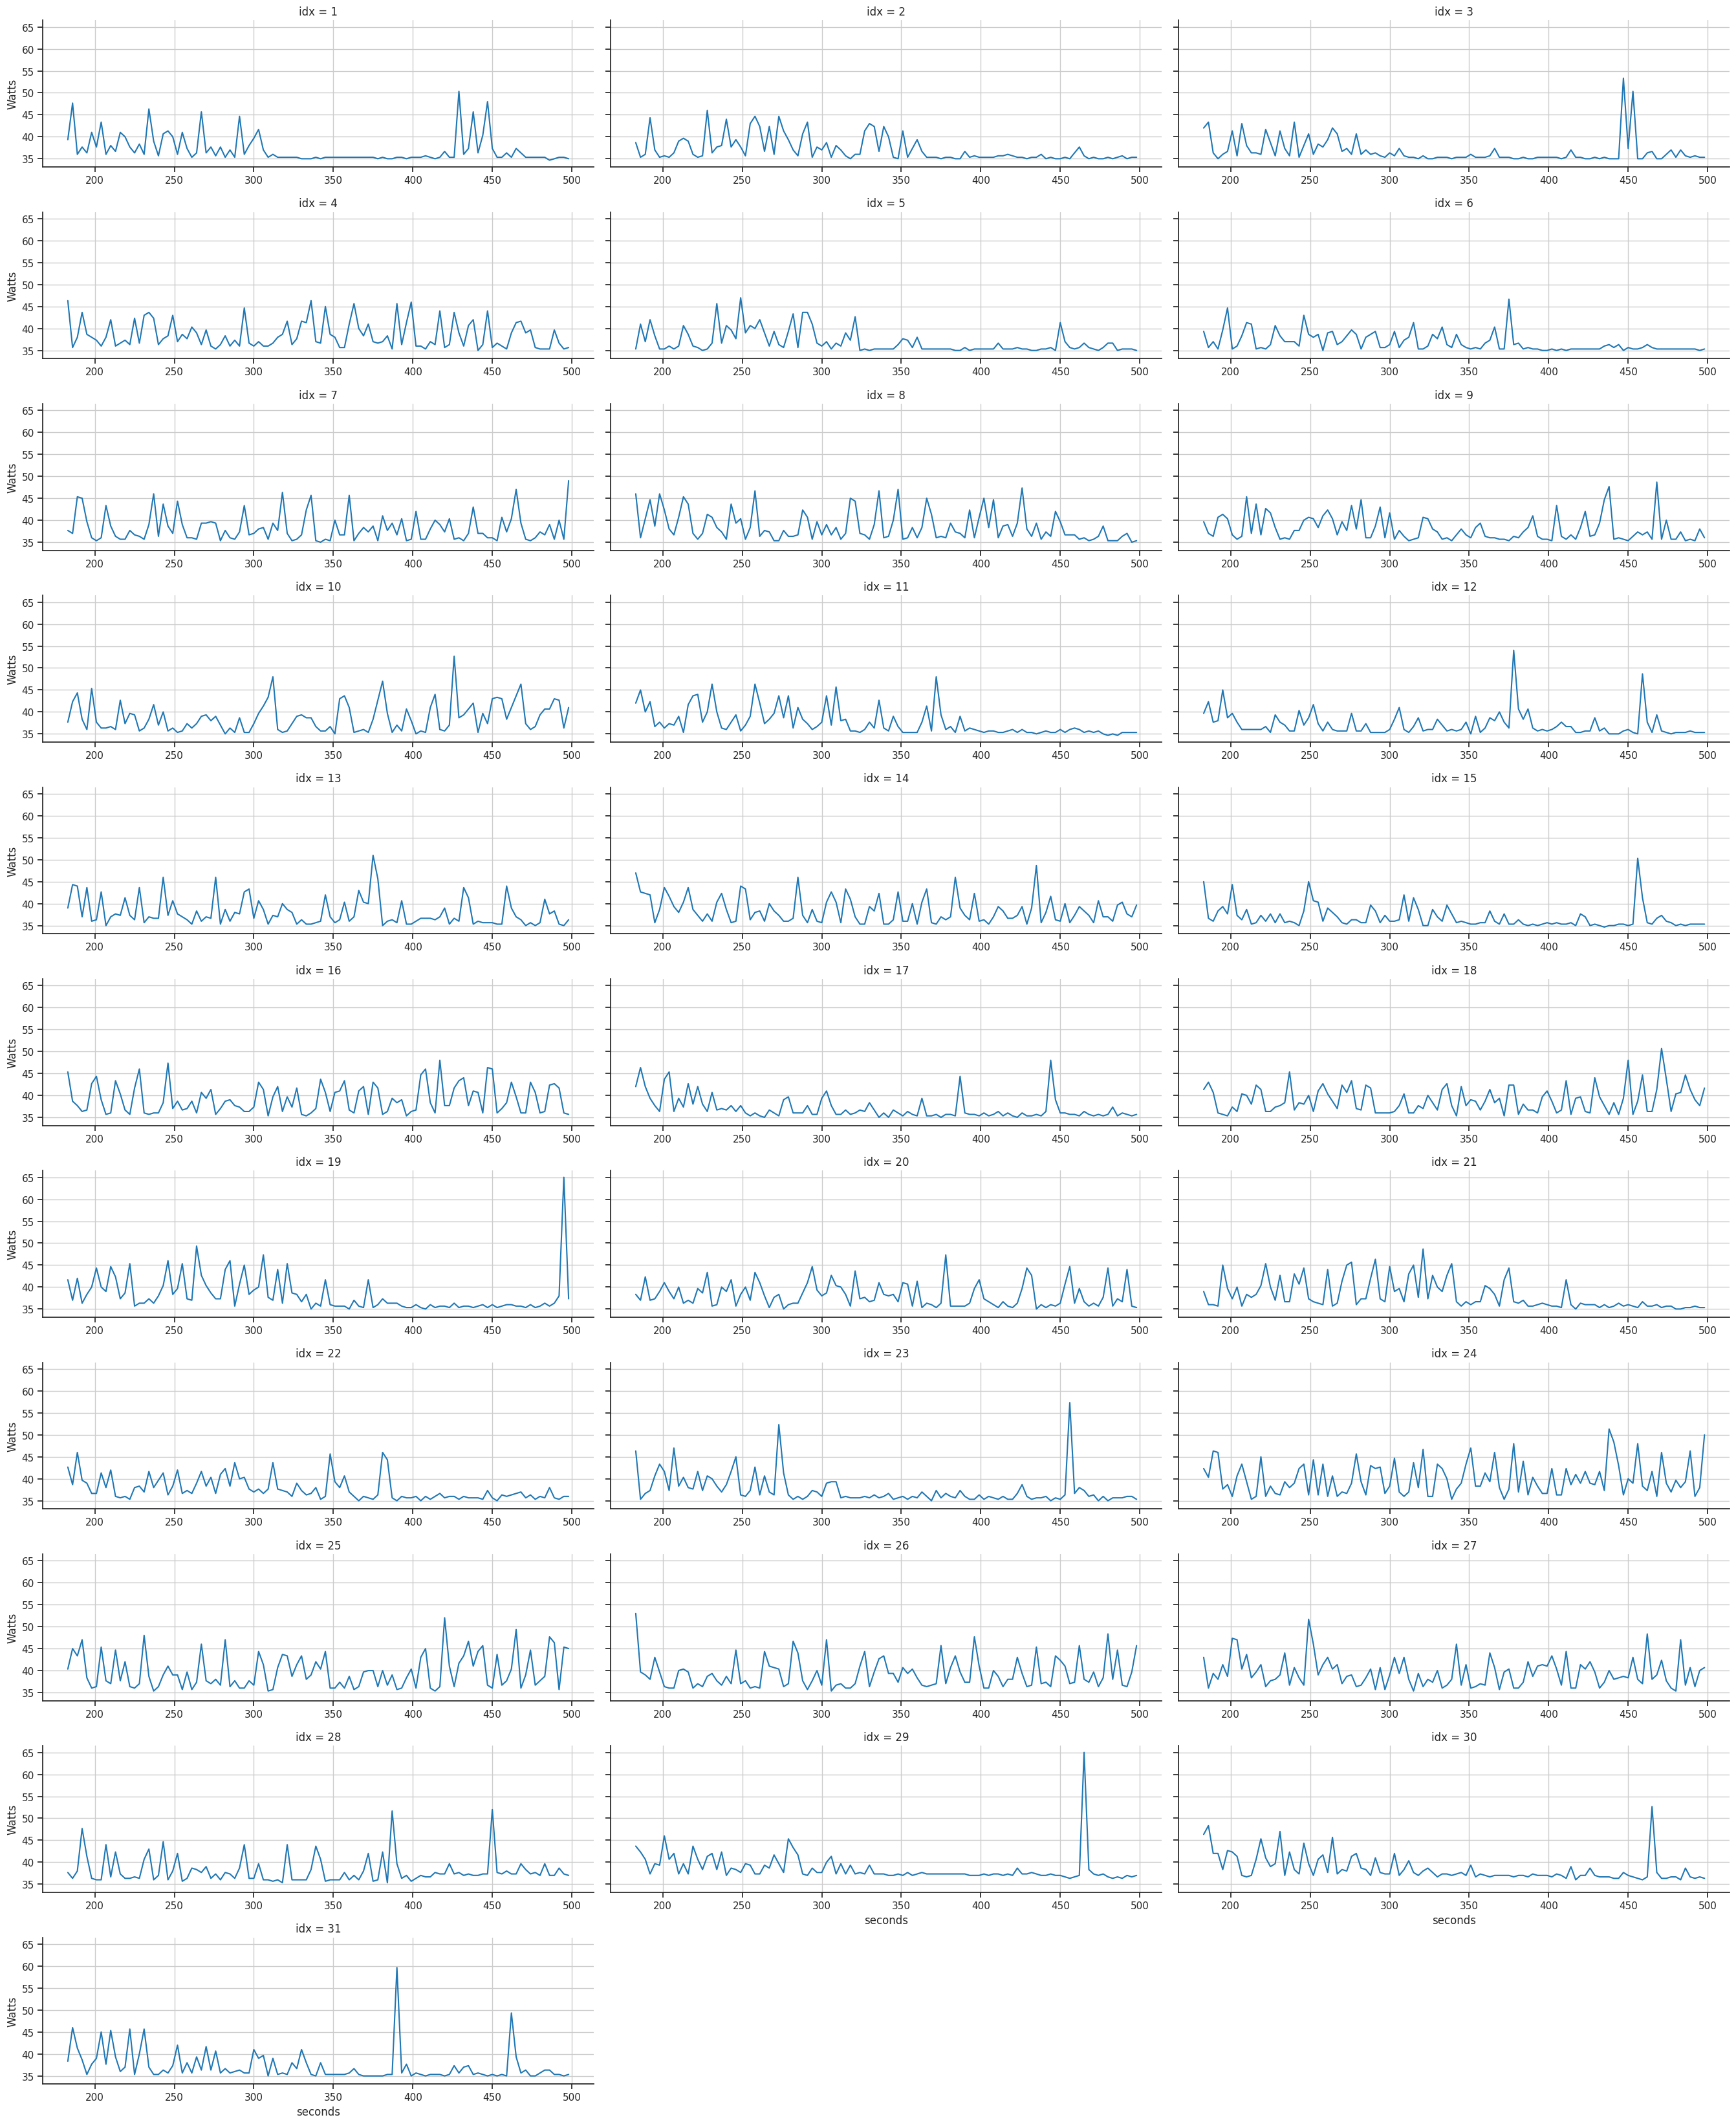

In [37]:
POWER_METRICS = pd.concat([prepare_dataframe("avg_over_time (epc1202PowerActive[3s])", data_measurement.loc[data_measurement['Variant'] == v], step=3).assign(variant=v) for v in VARIANTS])
# POWER_METRICS = pd.concat([prepare_dataframe("sum(avg by (mode) (rate(node_cpu_seconds_total{mode!='idle'}[3s]) * 100))", data_measurement.loc[data_measurement['Variant'] == v], step=3).assign(variant=v) for v in VARIANTS])

POWER_METRICS.columns.values[0] = "Watts"
POWER_METRICS = POWER_METRICS[POWER_METRICS['variant'] == 'microservice']
POWER_METRICS = POWER_METRICS.loc[(POWER_METRICS['seconds'] > 180) & (POWER_METRICS['seconds'] < 500)]

# sns.relplot(
#     data=POWER_METRICS,
#     x="seconds", y="A",
#     hue="idx", facet_kws=dict(sharex=False),
#     kind="line", aspect=3
# )
#g = sns.lmplot(x="seconds", y="A", col="idx", data=POWER_METRICS, truncate=False, col_wrap=3)

# Initialize a grid of plots with an Axes for each walk
g = sns.FacetGrid(POWER_METRICS, col="idx", hue="variant", col_wrap=3, sharex=False, aspect=3)
g.map(sns.lineplot, "seconds" ,"Watts")
plt.show()


## Power Consumption

,index,Watts,delta,seconds,idx,variant
0,2023-05-06 21:36:52,35.000000,0 days 00:00:00,0,4,microservice
1,2023-05-06 21:36:55,47.333333,0 days 00:00:03,3,4,microservice
2,2023-05-06 21:36:58,54.666667,0 days 00:00:06,6,4,microservice
3,2023-05-06 21:37:01,65.666667,0 days 00:00:09,9,4,microservice
4,2023-05-06 21:37:04,53.000000,0 days 00:00:12,12,4,microservice
...,...,...,...,...,...,...
4819,2023-05-07 19:56:03,36.333333,0 days 00:09:48,588,27,monolith
4820,2023-05-07 19:56:06,37.666667,0 days 00:09:51,591,27,monolith
4821,2023-05-07 19:56:09,35.000000,0 days 00:09:54,594,27,monolith
4822,2023-05-07 19:56:12,41.000000,0 days 00:09:57,597,27,monolith


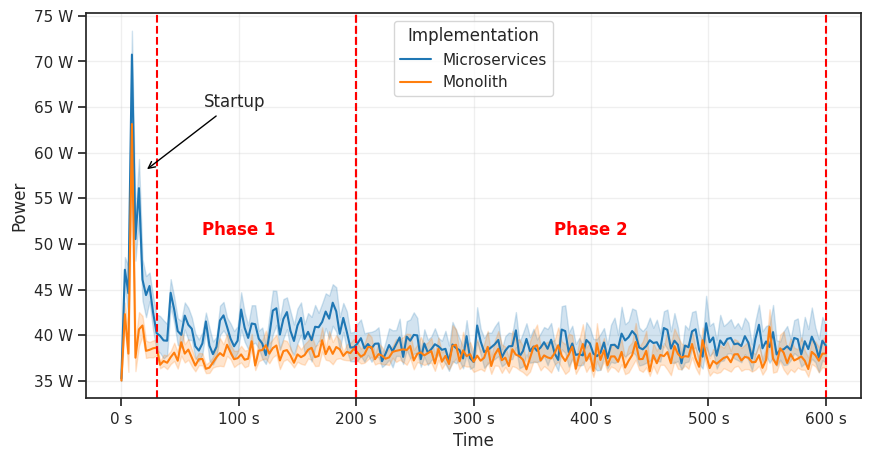

In [32]:
POWER_METRICS = pd.concat([prepare_dataframe("avg_over_time (epc1202PowerActive[3s])", data_measurement.loc[data_measurement['Variant'] == v], step=3).assign(variant=v) for v in VARIANTS])
POWER_METRICS.columns.values[0] = "Watts"
POWER_METRICS = POWER_METRICS.loc[(POWER_METRICS['idx'].isin([4, 7, 10, 13, 14, 16, 18, 20, 24, 25, 26, 27]))]

display(Markdown("## Power Consumption"))
POWER_METRICS.reset_index(inplace=True)
display(POWER_METRICS)

PHASE_1_START = 30
PHASE_1_END = 200
PHASE_2_START = 200
PHASE_2_END = 600

f = plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=POWER_METRICS, x="seconds", y="Watts", hue="variant"
)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.grid(alpha=0.3)
plt.axvline(x=PHASE_1_START, color='r', linestyle='--')
plt.axvline(x=PHASE_1_END, color='r', linestyle='--')
plt.axvline(x=PHASE_2_START, color='r', linestyle='--')
plt.axvline(x=PHASE_2_END, color='r', linestyle='--')
plt.annotate(text='Startup', xy=(20,58), xytext=(70,65), arrowprops=dict(arrowstyle="->", color='black'))
plt.text(100, 51, 'Phase 1', fontsize=12, color='r', fontweight='semibold', horizontalalignment='center')
plt.text(400, 51, 'Phase 2', fontsize=12, color='r', fontweight='semibold', horizontalalignment='center')
ax.set_xlabel("Time")
ax.set_ylabel("Power")
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['Microservices', 'Monolith'], title='Implementation')
plt.show()

In [33]:
def prepare_dungeon_dataframe(query, step=3):
    df = pd.concat([
        prepare_dataframe(query, data_measurement.loc[data_measurement['Variant'] == v], step=step).assign(variant=v) for v in VARIANTS
    ])
    # Remove everything that is not in the phases
    df = df.loc[(df['seconds'] >= PHASE_1_START) & (df['seconds'] <= PHASE_2_END)]
    df.loc[(df['seconds'] >= PHASE_1_START) & (df['seconds'] <= PHASE_1_END),'Phase'] = 1
    df.loc[(df['seconds'] >= PHASE_2_START) & (df['seconds'] <= PHASE_2_END),'Phase'] = 2
    df[['Phase']] = df[['Phase']].astype(int)
    return df

Outliers: 708


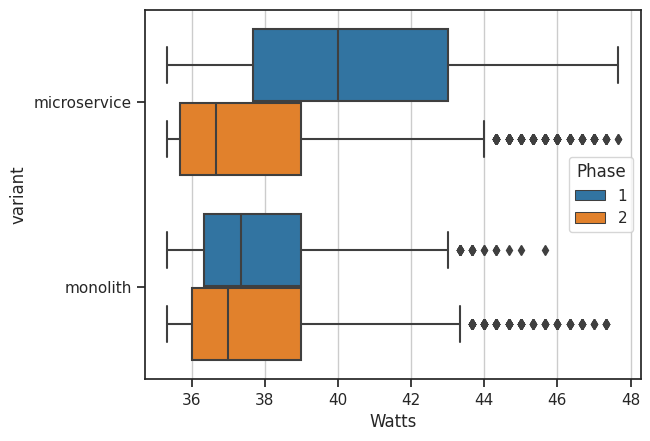

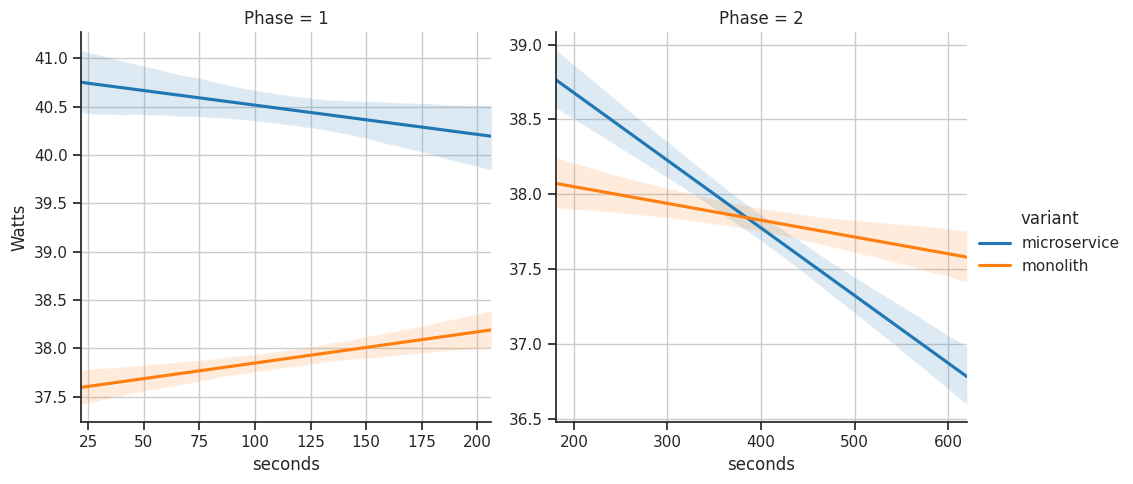

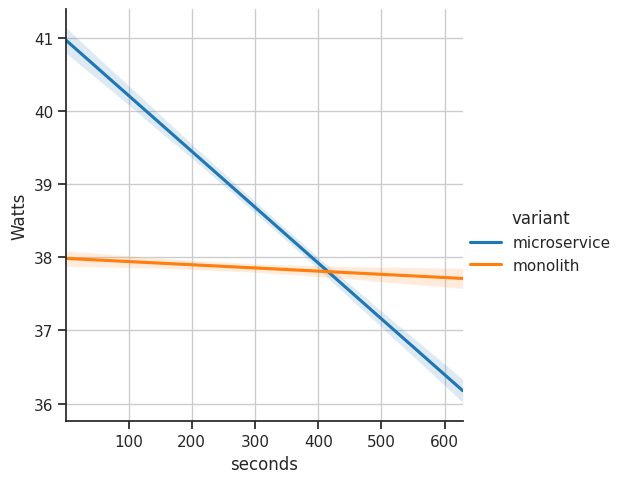

In [34]:
POWER_METRICS_PHASES = prepare_dungeon_dataframe("avg_over_time (epc1202PowerActive[3s])")
POWER_METRICS_PHASES.rename(columns={'{epc1202PowerIndex="1",instance="pdu.local",job="snmp"}': 'Watts'}, inplace=True)

q_low = POWER_METRICS_PHASES["Watts"].quantile(0.01)
q_hi  = POWER_METRICS_PHASES["Watts"].quantile(0.99)
outliers_cnt = len(POWER_METRICS_PHASES[(POWER_METRICS_PHASES["Watts"] >= q_hi) | (POWER_METRICS_PHASES["Watts"] <= q_low)])
print("Outliers: {}".format(outliers_cnt))

POWER_METRICS_PHASES = POWER_METRICS_PHASES[(POWER_METRICS_PHASES["Watts"] < q_hi) & (POWER_METRICS_PHASES["Watts"] > q_low)]

# Boxplot
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS_PHASES, hue="Phase")
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)

sns.lmplot(
    data=POWER_METRICS_PHASES,  x="seconds", y="Watts", hue="variant", col="Phase",
    scatter=False, truncate=False,
    facet_kws=dict(sharex=False, sharey=False)
)
plt.show()

sns.lmplot(
    data=POWER_METRICS_PHASES,  x="seconds", y="Watts", hue="variant",
    scatter=False, truncate=False,
    facet_kws=dict(sharex=False, sharey=False)
)
plt.show()

<Figure size 1500x300 with 0 Axes>

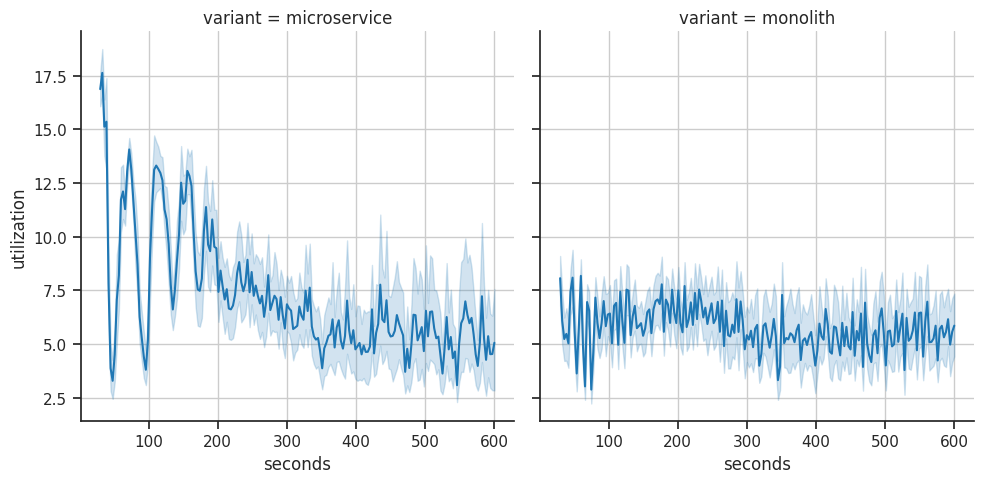

In [35]:
CPU_UTILIZATION = prepare_dungeon_dataframe("avg by (mode) (rate(node_cpu_seconds_total[3s]) * 100)")
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
# CPU_UTILIZATION = CPU_UTILIZATION.loc[:, ['seconds', 'variant', 'utilization']]

f = plt.figure(figsize=(15,3))
sns.relplot(
    data=CPU_UTILIZATION, x="seconds", y="utilization", col="variant", kind="line"
)
#fg.set_xlabels("Time (s)")
#fg.set_ylabels("CPU Utilization (%)")
plt.show(f)

AttributeError: 'Axes' object has no attribute 'set_xlabels'

<Figure size 1000x300 with 0 Axes>

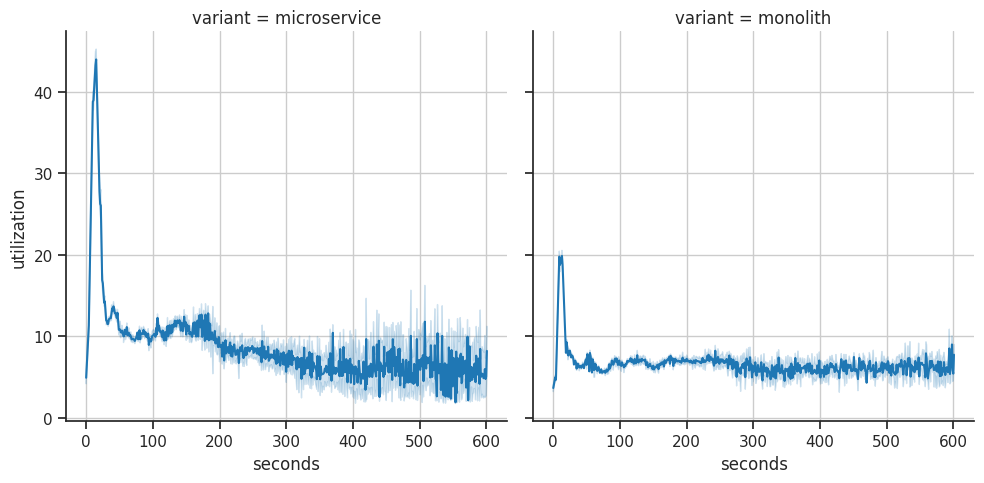

In [36]:
def get_cpu_peaks(df, order=1):
    df['utilization'] = df.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
    return df.iloc[argrelmax(df['utilization'].values, order=order)[0]]

CPU_UTILIZATION_PEAKS = pd.concat([
        get_cpu_peaks(prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v)) for v in VARIANTS
    ])
CPU_UTILIZATION_PEAKS = CPU_UTILIZATION_PEAKS.loc[:, ['seconds', 'variant', 'utilization']]
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION_PEAKS, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)